# ` Multiclass Classification ` Model Creation

## Scope

Do an feature engineering and mutliclass classification modelling on the HE Students Performance Evaluation dataset.

- Do basic EDA on features.

- Feature selection:- 

    1. Train test split
    
    2. Balance dataset
    
    3. Encode Ordinal and Nominal data into approppriate format.

    3. Check for correlation between features and target variable and select suitable features.
    
    4. Compare different classification models and choose most suitable.
    
    5. Choose final model and tune hyperparameters.

## Summary

- We defined the problem statement as a multiclass classifcation problem.

- Found the optimum train-test-split of 30% test data.

- Used SMOTE to oversample the minority class.

- Encoded the ordinal and nominal columns in approppriate format.

- Selected 10 best features using mutual information.

- Compared multiple classification models and chose Logistic Regression as the best one. Use macro f1-score as the performance metric.

- Hyperparameter tuned the final model for the best test accuracy. Provided a performance report.

- The model was overfitting significantly, but this was found to be due to a lack of sample size in training data.

**A reliable multiclassification model was concluded to be impossible with the current sample size. So a binary classification will be implemented to reduce complexity in the next notebook**.

### Imports

In [1]:
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

import imblearn
from imblearn.over_sampling import SMOTE

import pickle as pk

In [2]:
print(f'pandas:{pd.__version__}')
print(f'numpy:{np.__version__}')
print(f'sklearn:{sklearn.__version__}')
print(f'imblearn:{imblearn.__version__}')
print(f'seaborn:{sns.__version__}')
print(f'python:{sys.version}')

pandas:2.0.1
numpy:1.23.5
sklearn:1.2.2
imblearn:0.10.1
seaborn:0.12.2
python:3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


## Path

<ins>**Change the BASE path to your folder location**</ins>

In [3]:
BASE = r"C:\\Users\\anand\\Documents\\HE_Performance_3b"

PROCESSED = BASE + r"\\data\\processed\\"

EXPORT = BASE + r"\\data\\model\\"

## Read Data

In [4]:
# Read parquet
df = pd.read_parquet(PROCESSED + r"student_data.pqt")

# Preview
df.head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,total_salary,transport_uni,acc_type,...,prep_friends,prep_freq,notes,listening,discussion,flip-classroom,cgpa_last_sem,cgpa_expected,course_id,grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


In [5]:
# Shape of data
df.shape

(145, 32)

> **There are only 145 student samples with 31 features. There seems to be a severe lack of sample size required to get an accurate multiclass classification model that does not overfit.**

In [6]:
# Unique values and counts of grade
df.grade.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

**Some of the classes have very few samples, such as class 0 or Fail because only 8 out of 145 students have failed.**

We can see that the variable to be predicted, `Grade`, has multiple categorical data of grades representated as numbers 0 to 7. The goal of the project is to predict student performance. This can be done in multiple ways:-

- We create a multiclass classification model which predicts which grade the student will recieve.

- We predict which student is going to get high grades and pass by combining the grades 0-5 as 0 and 6-7 as 1, which then becomes a binary classification problem.

- We can consider the grades as a regression problem where we convert the grades to numbers 0-7 and try to find the expected grade in numerial format.

> Since no clear output format was specified to indicate performance, i will be choosing the 1st and 2nd option of **multiclass classification** in this notebook and **binary_classification** in the next notebook `03` for predicting student performance.

## Train-test Split

We will be performing feature engineering after train-test split, on training dataset seperately, to make sure there is no information leakage during testing.

In [7]:
# Train-test split
X_train, X_test, y_train, y_test=train_test_split(df.drop('grade',axis=1), df['grade'] , test_size=0.3,random_state=43)

Test size of 30% was found to be the best performing split. Since dataset is really small with multiple classes, no validation set was made.

In [8]:
# Length of training dataset
len(X_train)

101

In [9]:
# Length of testing dataset
len(X_test)

44

In [10]:
# Resetting indices
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

X_train.head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,total_salary,transport_uni,acc_type,...,attendance_classes,prep_friends,prep_freq,notes,listening,discussion,flip-classroom,cgpa_last_sem,cgpa_expected,course_id
0,1,1,1,5,2,1,2,1,1,1,...,1,1,1,3,1,3,1,2,4,9
1,1,2,2,5,1,2,1,1,4,2,...,1,1,2,3,1,2,3,4,4,1
2,1,2,2,4,2,1,1,1,2,3,...,1,1,1,3,2,3,2,2,3,7
3,2,1,2,3,1,2,1,1,2,1,...,1,1,1,2,3,1,2,4,2,5
4,1,2,2,3,2,2,1,1,1,1,...,2,1,1,3,1,3,3,3,2,1


## Balancing dataset

In [11]:
# Distribution of grade
y_train.value_counts()

grade
1    28
2    19
7    12
5    12
3    11
4     7
6     7
0     5
Name: count, dtype: int64

We also see that the data is not very balanced in the training dataset. We will be oversample the dataset so that each class has equal samples. Since the dataset is small, undersampling is not a viable strategy.

**The testing dataset will not be balanced since it should reflect the real-world distribution fo data.**

In [12]:
# SMOTE sampling
ros = SMOTE(sampling_strategy='auto',k_neighbors=2,random_state=43)

I used SMOTE algorithm for oversampling which created synthetic samples of minority class. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. I found `k_neighbhors=2` gave the best model accuracy.

In [13]:
# Resample dataest
X_train, y_train = ros.fit_resample(X_train, y_train)

In [14]:
# Length of dataset after sampling
len(X_train)

224

In [15]:
# Unique value of grade after sampling
y_train.value_counts()

grade
2    28
1    28
7    28
4    28
6    28
3    28
0    28
5    28
Name: count, dtype: int64

The target variable is balanced for the training set.

## Encoding

In [16]:
# Columns list
X_train.columns

Index(['age', 'sex', 'grad_hs', 'scholar_type', 'add_work', 'reg_art_sport',
       'partner', 'total_salary', 'transport_uni', 'acc_type', 'mother_edu',
       'father_edu', 'siblings', 'parental', 'mother_occ', 'father_occ',
       'weekly_study_hours', 'rf_non_scientific', 'rf_scientific',
       'attendance_seminar', 'impact', 'attendance_classes', 'prep_friends',
       'prep_freq', 'notes', 'listening', 'discussion', 'flip-classroom',
       'cgpa_last_sem', 'cgpa_expected', 'course_id'],
      dtype='object')

The ordinal columns are already in numerical format. But some features do not have the correct ranking such as:-

`impact`

`attendance_classes`

`prep_freq`

In [17]:
# Ordinal columns that need to be correctly ranked
incorrect_ordinal = [
    'impact',
    'attendance_classes',
    'prep_freq'
]

# Preview
X_train[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,1,1,1
1,1,1,2
2,1,1,1
3,3,1,1
4,1,2,1


In [18]:
# Correctly ranking ordinal columns
X_train['impact'] = X_train.impact.replace({2:1,3:2,1:3})


X_train['attendance_classes'] = X_train.attendance_classes.replace({3:1,1:3})


X_train['prep_freq'] = X_train.prep_freq.replace({3:1,1:2,2:3})

# Preview
X_train[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,3,3,2
1,3,3,3
2,3,3,2
3,2,3,2
4,3,2,2


The nominal columns have to be encoded using `OneHotEncoding`.

**OneHotEncoding will be done on training dataset first, then the same transformation will be applied to test data. This is to maintain feature consistency and prevent information leakage.**

In [19]:
# Nominal columns
nominal = [
    'age',
    'sex',
    'grad_hs',
    'scholar_type',
    'add_work',
    'reg_art_sport',
    'partner',
    'transport_uni',
    'acc_type',
    'parental',
    'mother_occ',
    'father_occ',
    'attendance_seminar',
    'prep_friends',
    'prep_freq',
    'flip-classroom',
    'course_id'
    
]

# Preview
X_train[nominal].head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,transport_uni,acc_type,parental,mother_occ,father_occ,attendance_seminar,prep_friends,prep_freq,flip-classroom,course_id
0,1,1,1,5,2,1,2,1,1,1,2,1,1,1,2,1,9
1,1,2,2,5,1,2,1,4,2,2,2,3,2,1,3,3,1
2,1,2,2,4,2,1,1,2,3,1,4,2,1,1,2,2,7
3,2,1,2,3,1,2,1,2,1,1,2,3,1,1,2,2,5
4,1,2,2,3,2,2,1,1,1,1,2,1,1,1,2,3,1


In [20]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [21]:
# Created one hot encoded array
nom_array = ohe.fit_transform(X_train[nominal]).toarray()

# Preview
nom_array

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [22]:
# Names of encoded features
ohe.get_feature_names_out()

array(['age_1', 'age_2', 'age_3', 'sex_1', 'sex_2', 'grad_hs_1',
       'grad_hs_2', 'grad_hs_3', 'scholar_type_2', 'scholar_type_3',
       'scholar_type_4', 'scholar_type_5', 'add_work_1', 'add_work_2',
       'reg_art_sport_1', 'reg_art_sport_2', 'partner_1', 'partner_2',
       'transport_uni_1', 'transport_uni_2', 'transport_uni_3',
       'transport_uni_4', 'acc_type_1', 'acc_type_2', 'acc_type_3',
       'acc_type_4', 'parental_1', 'parental_2', 'parental_3',
       'mother_occ_1', 'mother_occ_2', 'mother_occ_3', 'mother_occ_4',
       'mother_occ_5', 'father_occ_1', 'father_occ_2', 'father_occ_3',
       'father_occ_4', 'father_occ_5', 'attendance_seminar_1',
       'attendance_seminar_2', 'prep_friends_1', 'prep_friends_2',
       'prep_friends_3', 'prep_freq_1', 'prep_freq_2', 'prep_freq_3',
       'flip-classroom_1', 'flip-classroom_2', 'flip-classroom_3',
       'course_id_1', 'course_id_2', 'course_id_3', 'course_id_4',
       'course_id_5', 'course_id_6', 'course_id_7', '

In [23]:
# Drop original nominal columns
X_train = X_train.drop(nominal, axis = 1)

# Preview
X_train.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,listening,discussion,cgpa_last_sem,cgpa_expected
0,1,2,2,2,2,2,2,3,3,3,1,3,2,4
1,1,3,3,3,4,2,2,3,3,3,1,2,4,4
2,1,2,2,3,2,3,2,3,3,3,2,3,2,3
3,1,1,1,2,1,1,1,2,3,2,3,1,4,2
4,1,2,3,3,2,2,2,3,2,3,1,3,3,2


In [24]:
# Encoded columns
nom_df = pd.DataFrame(nom_array,columns = ohe.get_feature_names_out())

# Preview
nom_df.head()

,age_1,age_2,age_3,sex_1,sex_2,grad_hs_1,grad_hs_2,grad_hs_3,scholar_type_2,scholar_type_3,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Concat to original dataset
X_train = pd.concat([X_train,nom_df], axis=1)

# Preview
X_train.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,1,2,2,2,2,2,2,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,3,3,3,4,2,2,3,3,3,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2,3,2,3,2,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,1,2,1,1,1,2,3,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,2,3,3,2,2,2,3,2,3,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Doing the same transformation to test dataset

In [26]:
# Created one hot encoded array
test_array = ohe.transform(X_test[nominal]).toarray()

# Preview
test_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [27]:
# Drop original nominal columns
X_test = X_test.drop(nominal, axis = 1)

# Encoded columns
nom_df = pd.DataFrame(test_array,columns = ohe.get_feature_names_out())

# Concat to original dataset
X_test = pd.concat([X_test,nom_df], axis=1)

# Preview
X_test.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,4,2,3,5,3,2,2,1,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,2,2,2,2,1,2,2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,3,4,2,2,2,1,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,3,3,1,2,3,2,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,2,3,2,3,2,2,1,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After encoding, we have 73 columns. We will need to do some feature selection.

 ## Feature Selection

**A common rule of thumb is to have a minimum of 10-20 samples per predictor variable to avoid issues with overfitting. For this dataset, we have 4.67 (145/31) samples per predictor variable. The complexity of model is further increase by it being a multiclass classification model. By choosing a subset of very important features, we can minimise overfitting.**

**I will be using Mutual Information for selection features. The feature selection will be done on training set so as to prevent information leakage. Then the selected features will be filtered out from the test dataset seperately.**

In [28]:
# Determine the mutual information
mutual_info = mutual_info_classif(X_train, np.ravel(y_train), random_state = 43, discrete_features=True)

# Preview
mutual_info

array([0.13888045, 0.28653915, 0.17719987, 0.13034971, 0.19650793,
       0.15664683, 0.16834913, 0.06598736, 0.05820772, 0.19767039,
       0.08240154, 0.15135537, 0.41539571, 0.23972545, 0.05471774,
       0.06203346, 0.08316368, 0.20368058, 0.20368058, 0.11427351,
       0.10478413, 0.04038729, 0.0364171 , 0.02900023, 0.0560737 ,
       0.06295385, 0.11622685, 0.11622685, 0.11876767, 0.11876767,
       0.13203332, 0.13203332, 0.21018884, 0.1056921 , 0.05501869,
       0.03618404, 0.05243067, 0.03455881, 0.09431951, 0.00935393,
       0.03653549, 0.02421064, 0.01699778, 0.04192442, 0.08875309,
       0.04898546, 0.11273345, 0.01249902, 0.07014046, 0.04810879,
       0.04569934, 0.03984087, 0.03858983, 0.10808392, 0.10808392,
       0.04003325, 0.04729278, 0.03001772, 0.00935393, 0.03402781,
       0.03066673, 0.09930111, 0.06979173, 0.05420812, 0.25804352,
       0.01253997, 0.03700089, 0.03383265, 0.07237369, 0.24328515,
       0.09320077, 0.09363812, 0.1319421 ])

In [29]:
# Converting to dataframe
mutual_info = pd.Series(mutual_info)

# Preview
mutual_info.head()

0    0.138880
1    0.286539
2    0.177200
3    0.130350
4    0.196508
dtype: float64

In [30]:
# Setting column names to mutual information
mutual_info.index = X_train.columns

# Preview
mutual_info.head()

total_salary          0.138880
mother_edu            0.286539
father_edu            0.177200
siblings              0.130350
weekly_study_hours    0.196508
dtype: float64

In [31]:
# Sort by descending order of mutual information
mutual_info = mutual_info.sort_values(ascending = False)

# Preview
mutual_info.head(10)

cgpa_last_sem         0.415396
mother_edu            0.286539
course_id_1           0.258044
course_id_6           0.243285
cgpa_expected         0.239725
transport_uni_1       0.210189
sex_1                 0.203681
sex_2                 0.203681
notes                 0.197670
weekly_study_hours    0.196508
dtype: float64

<Axes: >

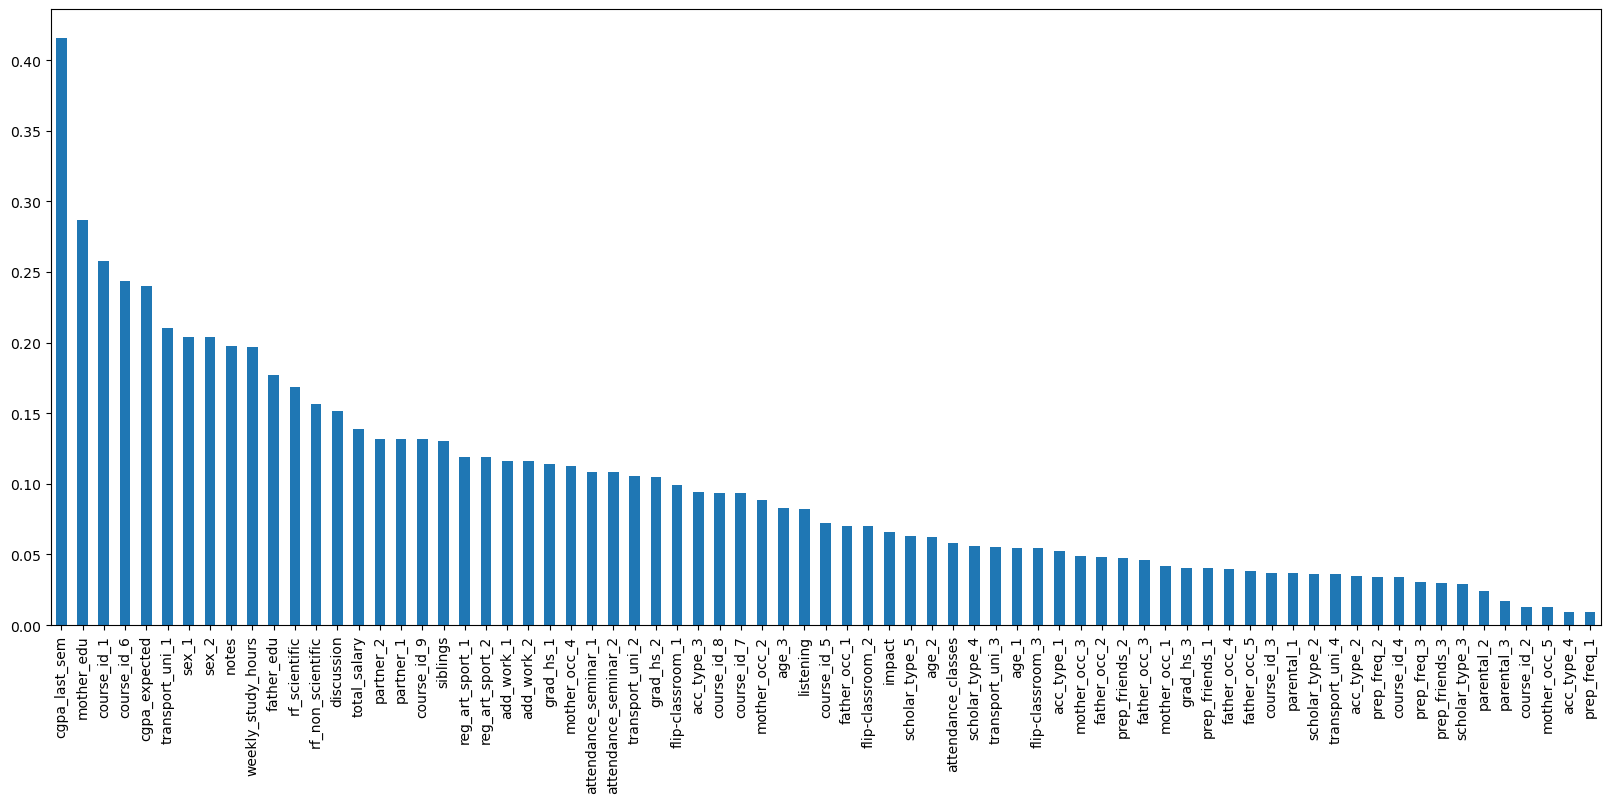

In [32]:
# Plot
mutual_info.sort_values(ascending = False).plot.bar(figsize =(20,8))

In [33]:
# Select the best features
best = mutual_info.index[0:10].to_list()

# Preview
best

['cgpa_last_sem',
 'mother_edu',
 'course_id_1',
 'course_id_6',
 'cgpa_expected',
 'transport_uni_1',
 'sex_1',
 'sex_2',
 'notes',
 'weekly_study_hours']

> **I varied the number of features selected and ran the model. I saw that choosing around 10 features gave me the highest model accuracy.**

I made sure that when changing the random_state of `mutual_info_classif`, i get the same top 10 important features consistently.

In [34]:
# Filtering features
X_train = X_train[best]

X_test = X_test[best]

X_train.head()

,cgpa_last_sem,mother_edu,course_id_1,course_id_6,cgpa_expected,transport_uni_1,sex_1,sex_2,notes,weekly_study_hours
0,2,2,0.0,0.0,4,1.0,1.0,0.0,3,2
1,4,3,1.0,0.0,4,0.0,0.0,1.0,3,4
2,2,2,0.0,0.0,3,0.0,0.0,1.0,3,2
3,4,1,0.0,0.0,2,0.0,1.0,0.0,2,1
4,3,2,1.0,0.0,2,1.0,0.0,1.0,3,2


<Axes: >

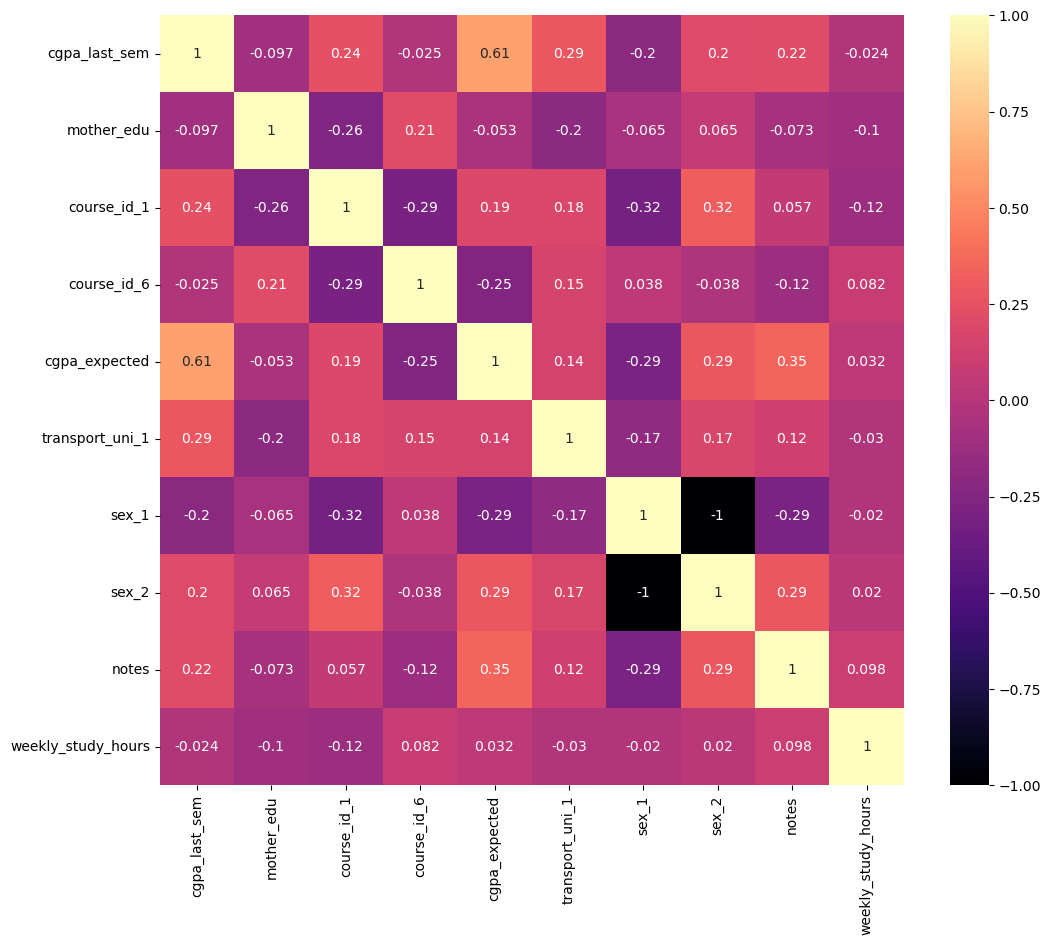

In [35]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(),annot=True,cmap='magma')

Here, `sex_1` and `sex_2` are perfectly collinear. But I am not removing it as the regularization of linear classification models will handle it.

## Modelling

We will be first testing multiple classifier models to compare.

In [36]:
# List of models to compare
models = {
    'Logistic Regression':LogisticRegression(multi_class='ovr', random_state=45),
    'Linear SVC':LinearSVC(max_iter = 10000,multi_class='ovr', random_state=45),
    'Decision Tree':DecisionTreeClassifier(random_state=45),
    'K-nearest Neighbhour':KNeighborsClassifier(),
    'Random Forest':RandomForestClassifier(random_state=45)
}

score = {}

In [37]:
for i in range(len(list(models))):
    
    #Select model
    model = list(models.values())[i]
    
    # Train model
    model.fit(X_train,y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    
    print('Model performance for training set \n')
    
    print(f" Training performance of {list(models.keys())[i]}: \n",classification_report(y_train, y_train_pred))
    
    print('Model performance for testing set \n')
    
    print(f" Testing performance of {list(models.keys())[i]}: \n",classification_report(y_test, y_test_pred))
    
    print('='*35)
    
    # Store in dictionary
    score[list(models.keys())[i]] = round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2)

Model performance for training set 

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        28
           1       0.46      0.39      0.42        28
           2       0.67      0.43      0.52        28
           3       0.59      0.71      0.65        28
           4       0.59      0.61      0.60        28
           5       0.56      0.54      0.55        28
           6       0.96      0.82      0.88        28
           7       0.79      0.96      0.87        28

    accuracy                           0.68       224
   macro avg       0.68      0.68      0.67       224
weighted avg       0.68      0.68      0.67       224

Model performance for testing set 

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.17      0.14      0.15         7
           2      

**Metric - F1 score**

- I chose **F1 score** as our metric since accuracy is a poor metric for unbalanced data. 

- F1-score was chosen over precison or recall since in this use case, we are equally interested in minimising False Positives and False Negatives.

- I specifically chose **macro average of F1-score** since the f1-score for each individual class is varying significantly. For weighted average, resulting performance is based on the proportion of every class. So in order to prevent f1 score of one class significantly biasing the average, i chose macro average since it does not consider the proportion of classes.

In [38]:
# Model accuracy
pd.DataFrame(score.items(),columns = ['model','test_f1_score']).sort_values('test_f1_score',ascending=False)

,model,test_f1_score
0,Logistic Regression,0.31
2,Decision Tree,0.27
1,Linear SVC,0.25
3,K-nearest Neighbhour,0.24
4,Random Forest,0.19


> **Logistic Regression performed the best.**

This makes sense since the dataset is small and prone to overfitting, simpler models such as Logistic Regression and Decision Trees would be better at generalising the model whereas more complex models such as Random Forest (without tuning) would perfectly fit the training data but would not generalise well to testing data.

### Final Model

I chose to do hyperparameter tuning manually and found that the simple default values worked best.

Note that the model used here is a variation of logistic regression for multiclass classification called `One-vs-Rest Classifier`. The basic idea behind the OvR classifier is to decompose the multiclass problem into multiple binary classification subproblems.

A `L2 Regularization` is done when fitting the model which will help in reducing overfitting and doing feature selection. It will also handle multicollinearity between features if it exists. 

There were two solvers, `lbfgs` and `liblinear` that supported multiclass classification where `lbfgs` proved slightly better. L1 Regularization is not supported by solved lbfgs for multiclass classification.

Max iteration was set to be 1000 to allow the model to converge.

In [39]:
# Logistic Regression (OnevsRest classifier for mutliclass)
lr = LogisticRegression(multi_class='ovr', penalty = 'l2', max_iter= 1000, C=1, solver = 'lbfgs',random_state=43)

lr.fit(X_train,y_train)

# Make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f" Training performance of Logistic Regression: \n",classification_report(y_train, y_train_pred))

print(f" Testing performance of Logistic Regression: \n",classification_report(y_test, y_test_pred))

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        28
           1       0.46      0.39      0.42        28
           2       0.67      0.43      0.52        28
           3       0.59      0.71      0.65        28
           4       0.59      0.61      0.60        28
           5       0.56      0.54      0.55        28
           6       0.96      0.82      0.88        28
           7       0.79      0.96      0.87        28

    accuracy                           0.68       224
   macro avg       0.68      0.68      0.67       224
weighted avg       0.68      0.68      0.67       224

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.17      0.14      0.15         7
           2       0.33      0.40      0.36         5
           3       0.62      0.50    

In [40]:
print("Training f1-score :",round(classification_report(y_train, y_train_pred,output_dict=True)['macro avg']['f1-score'],2))

print("Testing f1-score :",round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2))

Training f1-score : 0.67
Testing f1-score : 0.31


**Model Performance**

The model got a testing accuracy of 31% for predicting the student grade with a training accuracy of 67%. This means that the model is greatly overfitting. 

> **This is due to the fact that there is not enough training data due to having a small sample size. This can be demonstrated by the fact that changing the `random_state` of train-test-split gives different model accuracy. Because the data is very small and imbalanced, different data splits leads to variations in the representation of classes or important patterns in the data.**

Now let's look at the scores of each class individually.

In [41]:
# Individual class scores
score = {}
precision = []
recall = []
support = []

for i in range(0,8):
    
    # Get f1 score
    score[i] = round(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['f1-score'],2)
    
    # Get support
    precision.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['precision'])
    
    # Get support
    recall.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['recall'])
    
    # Get support
    support.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['support'])

# Append to dataframe   
out = pd.DataFrame(score.items(),columns = ['Class','Test_f1_score'])

# Add precision column
out['Precision'] = [round(x,2) for x in precision]

# Add recall column
out['Recall'] = [round(x,2) for x in recall]

# Add support column
out['Support'] = support

print('Scores for each class: \n')

# Preview
out[['Class','Support','Precision','Recall','Test_f1_score']].sort_values('Test_f1_score',ascending=False).reset_index(drop=True)

Scores for each class: 



,Class,Support,Precision,Recall,Test_f1_score
0,3,10,0.62,0.50,0.56
1,7,5,0.38,1.00,0.56
2,2,5,0.33,0.40,0.36
3,0,3,0.33,0.33,0.33
4,6,6,1.00,0.17,0.29
5,5,5,0.33,0.20,0.25
6,1,7,0.17,0.14,0.15
7,4,3,0.00,0.00,0.00


Looking at the individual f1 scores for each class, we see that grade CC and class 7 (AA) had the highest accuracy of 56% whereas class 4 (CB) had the lowest of 0%.

Class 6 (BA) had 100% precision. This means there were no False Positives for grade BA. All the samples that were predicted to be of grade BA was true.

Similarly, Class 7 (AA) had 100% recall. This means there were no False Negatives for grade AA. All the samples that were  not predicted to be of grade AA did not have that grade.

> **This means that although the overall model is unreliable, the model can be reliable for certain grades. If the model predicts a student will have grade BA, then we can trust it. Similarly if the model predicts the student will not have grade AA, then we can trust it.**

Class 3 (CC) and 7 (AA), even though the f1 scores are equal, they have highly differing ratios of precision and recall.

**Keep in mind that this is the performance of one single train-test split, different splits gives highly varying accuracy.**

In [42]:
# Grade labels
label = {
    0:'Fail',
    1:'DD',
    2:'DC',
    3:'CC',
    4:'CB',
    5:'BB',
    6:'BA',
    7:'AA'
}

# Replace values
out['Grade'] = out.Class.replace(label)

# Drop class column
out = out.drop('Class', axis=1)

# Preview
out[['Grade','Support','Precision','Recall','Test_f1_score']].sort_values('Test_f1_score',ascending=False).reset_index(drop=True)

,Grade,Support,Precision,Recall,Test_f1_score
0,CC,10,0.62,0.50,0.56
1,AA,5,0.38,1.00,0.56
2,DC,5,0.33,0.40,0.36
3,Fail,3,0.33,0.33,0.33
4,BA,6,1.00,0.17,0.29
5,BB,5,0.33,0.20,0.25
6,DD,7,0.17,0.14,0.15
7,CB,3,0.00,0.00,0.00


## Conclusion


After comparing different classifications, Logistic Regression model was used due to it performing the best. Also because the dataset was small and simpler models are prefered as simpler models generalise better to the testing dataset.

Due to the dataset being relatively small and imbalanced, different test-train data splits leads to variations in the representation of classes or important patterns in the data. This heavily impacts the model's ability to generalize and result in varying accuracy values.

The model had a test accuracy of 31% with a train accuracy of 67%. The test accuracy of different classes varied heavily. If the sample size of training dataset was increased, we could expect to have a much more accurate model.

#### **Since it is clear that mutliclass classification is not possible using this dataset, I will be doing a binary classification on the next notebook so that I can get a better performance with this dataset by reducing complexity.**

## Export model

In [43]:
# Model filename
filename = r'multiclass_model.pickle'

In [44]:
# Export file
pk.dump(lr, open(EXPORT+filename, 'wb'))